In [144]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
from nilearn import plotting
from nilearn.image import load_img, math_img, threshold_img, binarize_img
from nilearn.datasets import MNI152_FILE_PATH,load_mni152_brain_mask
print(MNI152_FILE_PATH)

/Users/carl/code/conda3/envs/nilearn-py3.10/lib/python3.10/site-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


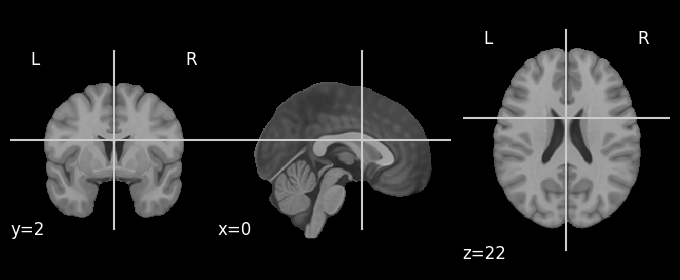

In [145]:
plotting.plot_anat(MNI152_FILE_PATH)

In [146]:
rois_coords = [(-20.3 , -2.27, -22.21),( 19.51, -1.85, -23.11)]
rois_labels = ['Amyg_L','Amyg_R']
sphere_radius = 7
print(any(isinstance(i, list) for i in rois_coords))
print(any(isinstance(i, tuple) for i in rois_coords))
print(' + found %d tuples of coordinates' % len(rois_coords))

False
True
 + found 2 tuples of coordinates


(197, 233, 189)
('R', 'A', 'S')
(1.0, 1.0, 1.0)


Text(0.5, 1.0, 'MNI152 mid-axial slice')

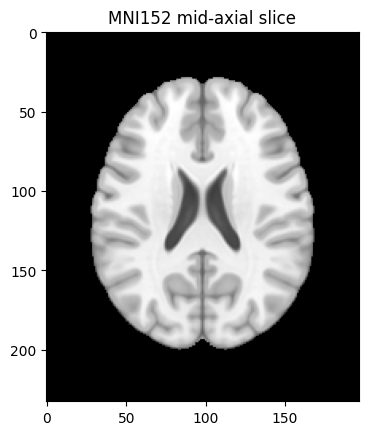

In [147]:
mni_img = load_img(MNI152_FILE_PATH)
#print(mni_img)
d = mni_img.get_fdata()
print(d.shape)
data_mni = np.asanyarray(mni_img.dataobj)
print(nib.aff2axcodes(mni_img.affine))
print(mni_img.header.get_zooms())
plt.imshow(np.flipud(data_mni[:, :, mni_img.shape[2]//2].T), cmap='gray')
plt.title('MNI152 mid-axial slice')

## Nibable Image Affine

A Nibabel image affine is a 4 x 4 numpy array, which describes the transformation from the voxel space (indices [i,j,k]) to reference space (distance in mm (x, y, z)).


Affine:
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Matrix Center: (98, 134, 72)


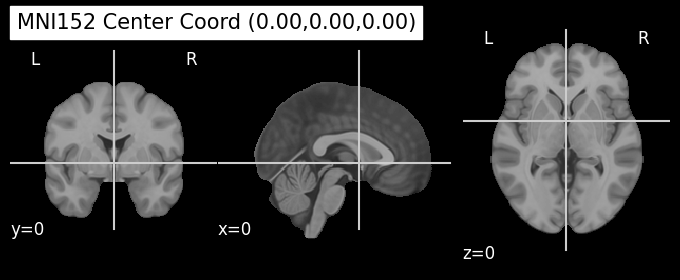

In [157]:
## get matrix i,j,k indices for real-world x,y,z coordinates (mm), in this case MNI152_1mm.
affine = mni_img.affine
rx,ry,rz = [0,0,0] #mni-coordinates (center of space)
i, j, k, _ = np.linalg.inv(affine).dot(np.array([rx,ry,rz,1])).astype(int)
print("Affine:")
print(affine)
print("Matrix Center: (%d, %d, %d)" % (i, j, k))
#mni_img.orthoview()
plotting.plot_anat(mni_img, cut_coords=[rx,ry,rz], title='MNI152 Center Coord (%.2f,%.2f,%.2f)'%(rx,ry,rz))

In [159]:
## get real-world x,y,z coordinates from i,j,k matrix coordinates.
x,y,z,_ = affine @ np.array([i,j,k,1])
print("matrix coords [%d,%d,%d] == Ref Image Coordinates (%.1f, %.1f, %.1f)" % (i,j,k, x,y,z))

matrix coords [77,131,49] == Ref Image Coordinates (-21.0, -3.0, -23.0)


Matrix Center: (77, 131, 49)


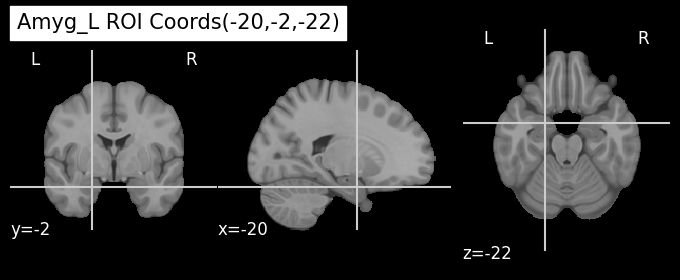

In [160]:
## determine matrix i,j,k from ROI Amyg_L coords in MNI-space
rx,ry,rz = rois_coords[0]
i, j, k, _ = np.linalg.inv(affine).dot(np.array([rx, ry, rz, 1])).astype(int)
print("Matrix Center: (%d, %d, %d)" % (i, j, k))
#mni_img.orthoview()
plotting.plot_anat(MNI152_FILE_PATH, cut_coords=[rx,ry,rz], title='%s ROI Coords(%d,%d,%d)'%(rois_labels[0],rx,ry,rz))


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 197 233 189   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -98.0
qoffset_y       : -134.0
qoffset_z       : -72.0
srow_x          : [  1.   0.   0. -98.]
srow_y      

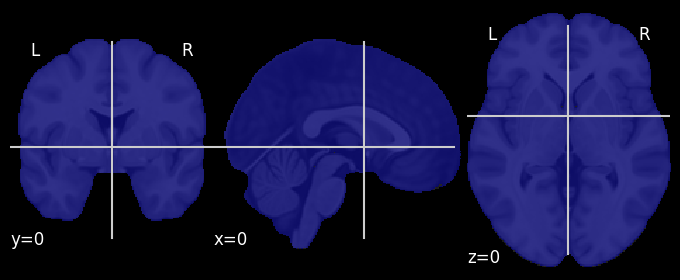

In [161]:
mni_brain_mask = load_mni152_brain_mask()
print(mni_brain_mask.header)
plotting.plot_roi(mni_brain_mask, cut_coords=[0,0,0], bg_img=MNI152_FILE_PATH)

In [162]:
## given x,y,z ref-img mm coordinates, radius, ref_img, return mask with sphere of radius
##   from: https://stackoverflow.com/questions/46626267/how-to-generate-a-sphere-in-3d-numpy-array
def create_sphere(xyz_coords, radius, ref_img):
    rx,ry,rz = xyz_coords
    i,j,k,_ = np.linalg.inv(ref_img.affine).dot(np.array([rx,ry,rz,1])).astype(int)
    dims = ref_img.shape
    m = [dims[0]/2, dims[1]/2, dims[2]/2]
    u,v,w = np.mgrid[0:dims[0]:1, 0:dims[1]:1, 0:dims[2]:1] # meshgrid size of img at 1mm
    a = np.sqrt((u - i)**2 + (v - j)**2 + (w - k)**2)
    a = a.astype(np.int32)
    a[a > radius] = 0
    #a[a < radius] = 1
    #b = np.where(a<=radius, 1, -1)
    print(' + DEBUG: a.shape:', a.shape)
    img = nib.Nifti1Image(a, affine=ref_img.affine, header=ref_img.header)
    return binarize_img(img)

 + DEBUG: a.shape: (197, 233, 189)


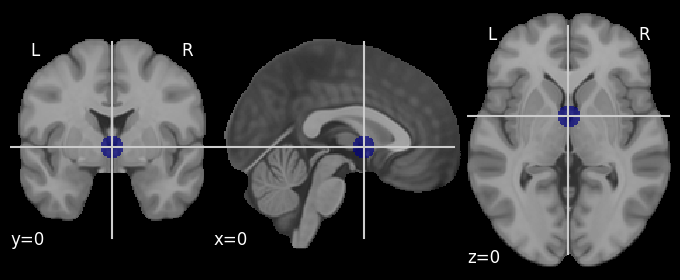

In [163]:
mni_center_ijk = (98, 134, 72)
mni_center_xyz = (0,0,0)
sp_roi = create_sphere(mni_center_xyz, sphere_radius, mni_brain_mask)
plotting.plot_roi(sp_roi, cut_coords=mni_center_xyz, bg_img=MNI152_FILE_PATH)

 + DEBUG: a.shape: (197, 233, 189)
 + AmygL_sphere_mask.header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 197 233 189   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -98.0
qoffset_y       : -134.0
qoffset_z 

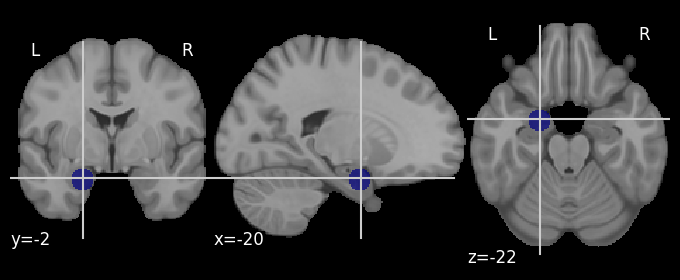

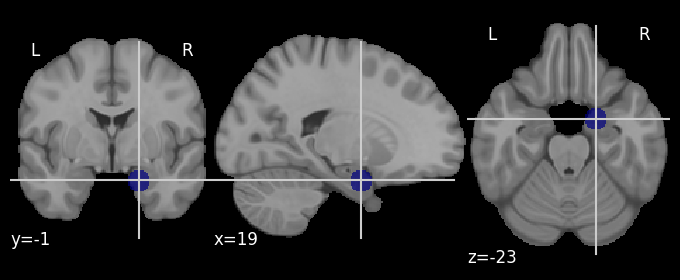

In [164]:
AmygL_sphere_mask = create_sphere(rois_coords[0], sphere_radius, mni_brain_mask)
print(' + AmygL_sphere_mask.header:',AmygL_sphere_mask.header)
plotting.plot_roi(AmygL_sphere_mask, cut_coords=rois_coords[0], bg_img=MNI152_FILE_PATH)
AmygR_sphere_mask = create_sphere(rois_coords[1], sphere_radius, mni_brain_mask)
print(' + AmygR_sphere_mask.header:',AmygR_sphere_mask.header)
plotting.plot_roi(AmygR_sphere_mask, cut_coords=rois_coords[1], bg_img=MNI152_FILE_PATH)

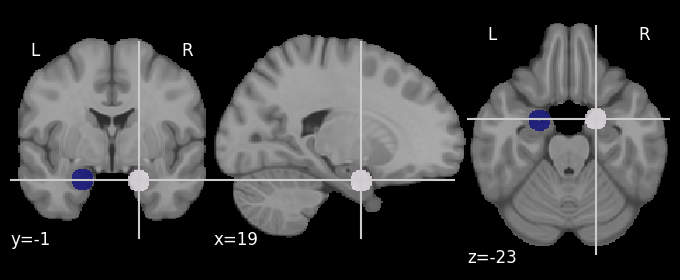

In [165]:
rois_merged_img = math_img('a + b*2', a=AmygL_sphere_mask, b=AmygR_sphere_mask)
plotting.plot_roi(rois_merged_img, cut_coords=rois_coords[1], bg_img=MNI152_FILE_PATH)